# Kernel Density Estimation

Based on Chapter 5 from *Python for Data Science Handbook*, by Jake VanderPlas.

In the previous section we covered Gaussian mixture models (GMM), which are a kind of hybrid between a clustering estimator and a density estimator.
Recall that a density estimator is an algorithm which takes a $D$-dimensional dataset and produces an estimate of the $D$-dimensional probability distribution which that data is drawn from.
The GMM algorithm accomplishes this by representing the density as a weighted sum of Gaussian distributions.
*Kernel density estimation* (KDE) is in some senses an algorithm which takes the mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one Gaussian component *per point*, resulting in an essentially non-parametric estimator of density.
In this section, we will explore the motivation and uses of KDE.

We begin with the standard imports:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings("ignore")

## Motivating KDE: Histograms

As already discussed, a density estimator is an algorithm which seeks to model the probability distribution that generated a dataset.
For one dimensional data, you are probably already familiar with one simple density estimator: the histogram.
A histogram divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner.

For example, let's create some data that is drawn from two normal distributions:

In [2]:
# Function to generate a 1D dataset with a mixture of two distributions
def make_data(N, f=0.3, rseed=1):
    
    """
    Generates a dataset with N samples, mixing two distributions:
    - The first part of the data is drawn from a standard normal distribution.
    - The second part is shifted by a constant value to create a distinct group.

    Parameters:
    - N (int): Total number of data points to generate.
    - f (float): Fraction of data points in the first group (from the standard normal distribution).
    - rseed (int): Seed for the random number generator to ensure reproducibility.

    Returns:
    - x (numpy.ndarray): The generated dataset as a 1D NumPy array.
    """
    
    rand = np.random.RandomState(rseed)  # Set the random seed for reproducibility
    
    x = rand.randn(N)                    # Generate N samples from a standard normal distribution
    
    x[int(f * N):] += 5                  # Shift a fraction (1-f) of the data by adding 5
    
    return x

# Generate a dataset with 1000 samples using the make_data function
x = make_data(1000)

We have previously seen that the standard count-based histogram can be created with the ``plt.hist()`` function.
By specifying the ``normed`` parameter of the histogram, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflects probability density:

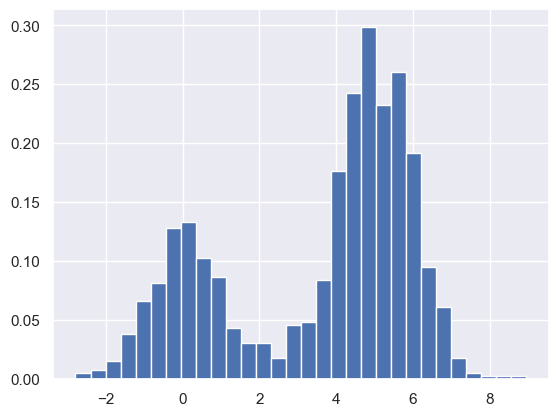

In [3]:
# Plot a histogram of the data with 30 bins (30 equal intervals), normalized to show probability density
hist = plt.hist(x, bins=30, density=True)

# Display the histogram plot
plt.show()

Notice that for equal binning, this normalization simply changes the scale on the y-axis, leaving the relative heights essentially the same as in a histogram built from counts. This normalization is chosen so that the total area under the histogram is equal to 1, as we can confirm by looking at the output of the histogram function:

In [4]:
# Extract the density, bins, and patches from the histogram plot data
density, bins, patches = hist

# Calculate the width of each bin by subtracting the left edge of each bin from the right edge
widths = bins[1:] - bins[:-1]

# Compute the total area under the histogram by multiplying the density of each bin
# by the corresponding bin width and summing these values.
# This represents the integral of the density function over the data range.
total_area = (density * widths).sum()
total_area

1.0

In [5]:
density

array([0.00510565, 0.00765847, 0.01531695, 0.03829237, 0.06637345,
       0.08169039, 0.12764124, 0.13274689, 0.10211299, 0.08679604,
       0.04339802, 0.0306339 , 0.0306339 , 0.01786977, 0.04595085,
       0.04850367, 0.08424322, 0.17614491, 0.24251836, 0.2986805 ,
       0.23230706, 0.26038813, 0.19146186, 0.09445452, 0.0612678 ,
       0.01786977, 0.00510565, 0.00255282, 0.00255282, 0.00255282])

In [6]:
widths

array([0.39172292, 0.39172292, 0.39172292, 0.39172292, 0.39172292,
       0.39172292, 0.39172292, 0.39172292, 0.39172292, 0.39172292,
       0.39172292, 0.39172292, 0.39172292, 0.39172292, 0.39172292,
       0.39172292, 0.39172292, 0.39172292, 0.39172292, 0.39172292,
       0.39172292, 0.39172292, 0.39172292, 0.39172292, 0.39172292,
       0.39172292, 0.39172292, 0.39172292, 0.39172292, 0.39172292])

In [7]:
density * widths

array([0.002, 0.003, 0.006, 0.015, 0.026, 0.032, 0.05 , 0.052, 0.04 ,
       0.034, 0.017, 0.012, 0.012, 0.007, 0.018, 0.019, 0.033, 0.069,
       0.095, 0.117, 0.091, 0.102, 0.075, 0.037, 0.024, 0.007, 0.002,
       0.001, 0.001, 0.001])

In [8]:
(density * widths).sum()

1.0

One of the issues with using a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features. For example, if we look at a version of this data with only 20 points, the choice of how to draw the bins can lead to an entirely different interpretation of the data! Consider this example:

In [9]:
# Generate a dataset with 20 data points using the `make_data` function
x = make_data(20)

# Create an array of bin edges for a histogram, ranging from -5 to 10, with 10 bins
bins = np.linspace(-5, 10, 10)

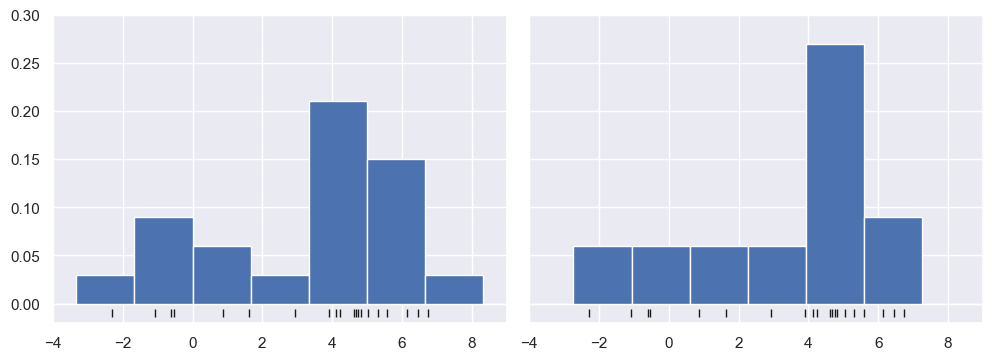

In [10]:
# Create a figure and a set of subplots with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,                            # The x and y axes are shared across subplots
                       subplot_kw={'xlim': (-4, 9), 'ylim': (-0.02, 0.3)})  # Sets the x-axis and y-axis limits (ylim) for both subplots

# Adjust the space between the subplots
fig.subplots_adjust(wspace=0.05)

# Loop over two different histogram offsets
for i, offset in enumerate([0.0, 0.6]):
    
    # Plot a histogram of the data `x` with specified bins, shifted by `offset`
    ax[i].hist(x, bins=bins + offset, density=True)
    
    # Plot the data points as vertical lines below the x-axis
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

On the left, the histogram makes clear that this is a bimodal distribution.
On the right, we see a unimodal distribution with a long tail.
Without seeing the preceding code, you would probably not guess that these two histograms were built from the same data: with that in mind, how can you trust the intuition that histograms confer?
And how might we improve on this?

Stepping back, we can think of a histogram as a stack of blocks, where we stack one block within each bin on top of each point in the dataset.
Let's view this directly:

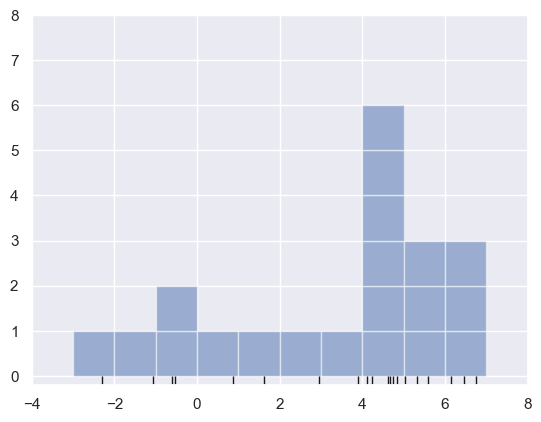

In [11]:
# Create a figure and a single set of axes (subplots with 1 row and 1 column)
fig, ax = plt.subplots()

# Define the bin edges for the histogram
bins = np.arange(-3, 8)

# Plot the data points `x` as vertical lines below the x-axis at y = -0.1
ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

# Create a histogram manually and draw rectangles for each bin

# `edge` represents the left edge of each bin
for count, edge in zip(*np.histogram(x, bins)):
    
    for i in range(count):                                       # `count` represents the number of data points in each bin
        
        # Add a rectangle patch for each count in the bin
        # The rectangle starts at (edge, i), with width 1 and height 1       
        ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha=0.5))  # `alpha=0.5` sets the transparency of the rectangles

# Set the limits for the x and y axes
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8);

The problem with our two binnings stems from the fact that the height of the block stack often reflects not on the actual density of points nearby, but on coincidences of how the bins align with the data points.
This mis-alignment between points and their blocks is a potential cause of the poor histogram results seen here.
But what if, instead of stacking the blocks aligned with the *bins*, we were to stack the blocks aligned with the *points they represent*?
If we do this, the blocks won't be aligned, but we can add their contributions at each location along the x-axis to find the result.
Let's try this:

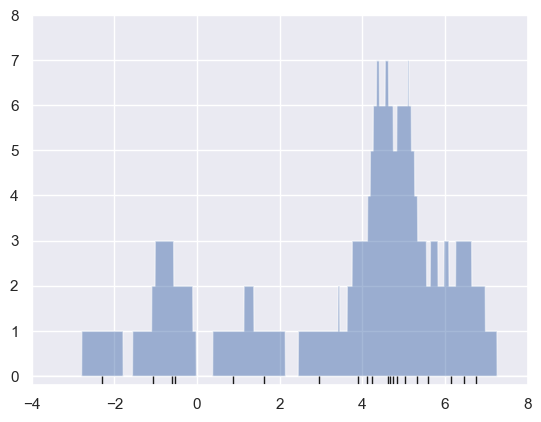

In [12]:
# Create an array of 2000 points between -4 and 8 for the x-axis
x_d = np.linspace(-4, 8, 2000)

# Calculate the density at each point in x_d using a uniform kernel
# The kernel is defined as 1 where |xi - x_d| < 0.5, and 0 otherwise
density = sum((abs(xi - x_d) < 0.5) for xi in x)

# Plot the density as a filled area plot with semi-transparency
plt.fill_between(x_d, density, alpha=0.5)

# Plot the original data points as vertical lines below the x-axis
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

# Set the x and y axis limits
plt.axis([-4, 8, -0.2, 8]);

The result looks a bit messy, but is a much more robust reflection of the actual data characteristics than is the standard histogram.
Still, the rough edges are not aesthetically pleasing, nor are they reflective of any true properties of the data.
In order to smooth them out, we might decide to replace the blocks at each location with a smooth function, like a Gaussian.
Let's use a standard normal curve at each point instead of a block:

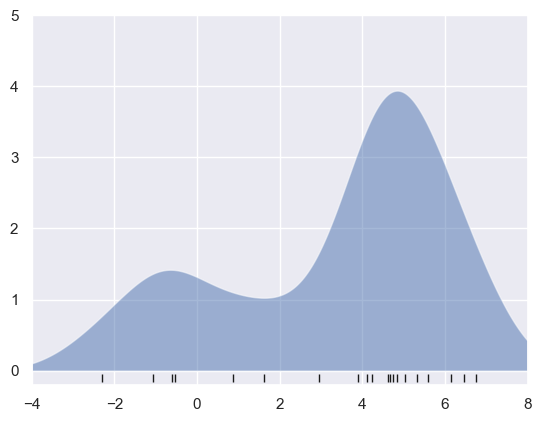

In [13]:
from scipy.stats import norm

# Create an array of 1000 points between -4 and 8 for the x-axis
x_d = np.linspace(-4, 8, 1000)

# Calculate the density at each point in x_d using Gaussian kernels
# The density is the sum of the Gaussian probability density functions (PDFs)
# centered at each data point xi in x, evaluated at each point in x_d
density = sum(norm(xi).pdf(x_d) for xi in x)

# Plot the density as a filled area plot with semi-transparency
plt.fill_between(x_d, density, alpha=0.5)

# Plot the original data points as vertical lines below the x-axis
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

# Set the x and y axis limits
plt.axis([-4, 8, -0.2, 5]);

This smoothed-out plot, with a Gaussian distribution contributed at the location of each input point, gives a much more accurate idea of the shape of the data distribution, and one which has much less variance (i.e., changes much less in response to differences in sampling).

These last two plots are examples of kernel density estimation in one dimension: the first uses a so-called "tophat" kernel and the second uses a Gaussian kernel.
We'll now look at kernel density estimation in more detail.

## Kernel Density Estimation in Practice

The free parameters of kernel density estimation are the *kernel*, which specifies the shape of the distribution placed at each point, and the *kernel bandwidth*, which controls the size of the kernel at each point.
In practice, there are many kernels you might use for a kernel density estimation: in particular, the Scikit-Learn KDE implementation supports one of six kernels, which you can read about in Scikit-Learn's [Density Estimation documentation](http://scikit-learn.org/stable/modules/density.html).

While there are several versions of kernel density estimation implemented in Python (notably in the SciPy and StatsModels packages), I prefer to use Scikit-Learn's version because of its efficiency and flexibility.
It is implemented in the ``sklearn.neighbors.KernelDensity`` estimator, which handles KDE in multiple dimensions with one of six kernels and one of a couple dozen distance metrics.
Because KDE can be fairly computationally intensive, the Scikit-Learn estimator uses a tree-based algorithm under the hood and can trade off computation time for accuracy using the ``atol`` (absolute tolerance) and ``rtol`` (relative tolerance) parameters.
The kernel bandwidth, which is a free parameter, can be determined using Scikit-Learn's standard cross validation tools as we will soon see.

Let's first show a simple example of replicating the above plot using the Scikit-Learn ``KernelDensity`` estimator:

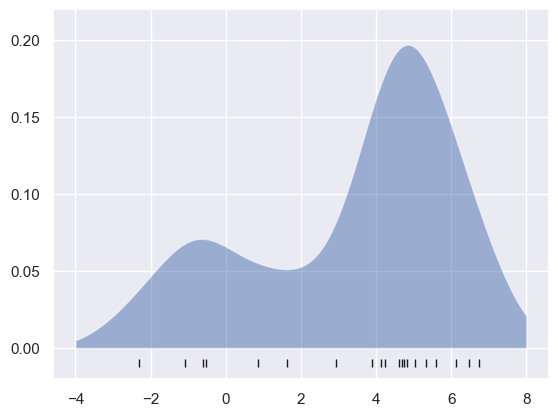

In [14]:
from sklearn.neighbors import KernelDensity

# Instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

# Plot the density as a filled area plot with semi-transparency
plt.fill_between(x_d, np.exp(logprob), alpha=0.5)

# Plot the original data points as vertical lines below the x-axis
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

# Set the y-axis limit
plt.ylim(-0.02, 0.22);

The result here is normalized such that the area under the curve is equal to 1.

### Selecting the bandwidth via cross-validation

The choice of bandwidth within KDE is extremely important to finding a suitable density estimate, and is the knob that controls the bias–variance trade-off in the estimate of density: too narrow a bandwidth leads to a high-variance estimate (i.e., over-fitting), where the presence or absence of a single point makes a large difference. Too wide a bandwidth leads to a high-bias estimate (i.e., under-fitting) where the structure in the data is washed out by the wide kernel.

There is a long history in statistics of methods to quickly estimate the best bandwidth based on rather stringent assumptions about the data: if you look up the KDE implementations in the SciPy and StatsModels packages, for example, you will see implementations based on some of these rules.

In machine learning contexts, we've seen that such hyperparameter tuning often is done empirically via a cross-validation approach.
With this in mind, the ``KernelDensity`` estimator in Scikit-Learn is designed such that it can be used directly within the Scikit-Learn's standard grid search tools.
Here we will use ``GridSearchCV`` to optimize the bandwidth for the preceding dataset.
Because we are looking at such a small dataset, we will use leave-one-out cross-validation, which minimizes the reduction in training set size for each cross-validation trial:

In [15]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut

# Define a range of bandwidths to search over, using a log scale
bandwidths = 10 ** np.linspace(-1, 1, 100)

# Set up GridSearchCV with KernelDensity and LeaveOneOut cross-validation
grid = GridSearchCV(KernelDensity(kernel='gaussian'),  # Specifies the model for which we want to tune the hyperparameters
                    {'bandwidth': bandwidths},         # The GridSearchCV will search through these values to find the optimal bandwidth.
                    cv=LeaveOneOut())                  # Each of the len(x) data points will be left out once during training to be used as a test set.

# Fit the grid search to the data
grid.fit(x[:, None])

GridSearchCV(cv=LeaveOneOut(), estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.305385...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ])})

Now we can find the choice of bandwidth which maximizes the score (which in this case defaults to the log-likelihood):

In [16]:
# Get the best bandwidth found by GridSearchCV
best_params = grid.best_params_

best_params

{'bandwidth': 1.1233240329780276}

The optimal bandwidth happens to be very close to what we used in the example plot earlier, where the bandwidth was 1.0 (i.e., the default width of ``scipy.stats.norm``).

## Example: KDE on a Sphere

Perhaps the most common use of KDE is in graphically representing distributions of points.
For example, in the Seaborn visualization library, KDE is built in and automatically used to help visualize points in one and two dimensions.

Here we will look at a slightly more sophisticated use of KDE for visualization of distributions.
We will make use of some geographic data that can be loaded with Scikit-Learn: the geographic distributions of recorded observations of two South American mammals, *Bradypus variegatus* (the Brown-throated Sloth) and *Microryzomys minutus* (the Forest Small Rice Rat).

With Scikit-Learn, we can fetch this data as follows:

In [17]:
from sklearn.datasets import fetch_species_distributions

# Fetch the species distributions dataset
data = fetch_species_distributions()

# Extract the latitude and longitude data from the training set and stack them together.
# This creates an array where each row corresponds to a species occurrence with its
# latitude (first column) and longitude (second column).
latlon = np.vstack([data.train['dd lat'], data.train['dd long']]).T

# Convert species names from bytes to strings and check if they start with 'micro'.
# If they do, the corresponding species ID is set to 1; otherwise, it is set to 0.
# This creates a binary array where 1 represents 'micro' species and 0 represents others.
species = np.array([d.decode('ascii').startswith('micro') for d in data.train['species']], dtype='int')

With this data loaded, we can use the Cartopy toolkit to plot the observed locations of these two species on the map of South America.

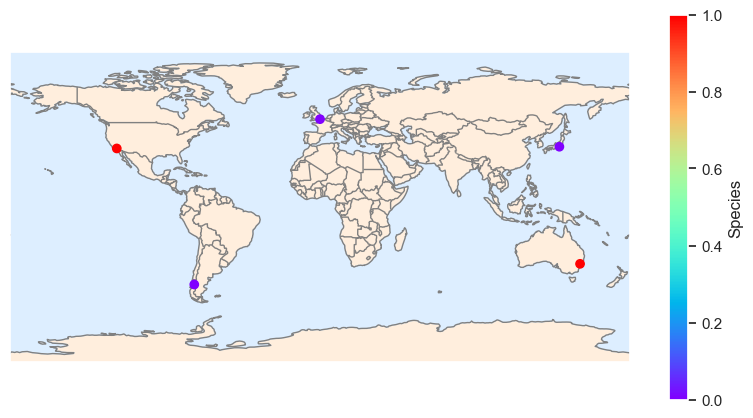

In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Sample data (latitude and longitude)
latlon = [[-45, -73], [34, -118], [51, 0], [-33, 151], [35, 139]]     # Replace with actual data
species = [0, 1, 0, 1, 0]                                             # Replace with actual data

# Create a map with a cylindrical projection
fig, ax = plt.subplots(figsize=(10, 5), 
                       subplot_kw={'projection': ccrs.PlateCarree()}) # A map in a cylindrical projection

ax.set_extent([-180, 180, -90, 90])     # Set the extent to the full world

# Add map features
ax.add_feature(cfeature.LAND, color='#FFEEDD')        # Adds land features with a light color.
ax.add_feature(cfeature.OCEAN, color='#DDEEFF')       # Adds ocean features with a light blue color.
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')  # Adds coastline features with gray borders.
ax.add_feature(cfeature.BORDERS, edgecolor='gray')    # Adds country borders with gray lines.

# Plot the locations of the species
latlon = np.array(latlon)         # Convert latlon list to a NumPy array
plt.scatter(latlon[:, 1],         # Plots the latitude and longitude points on the map.
            latlon[:, 0], 
            c=species,                      # Colors the points based on species category.
            cmap='rainbow',                 # Uses a rainbow color map to distinguish species.
            transform=ccrs.PlateCarree(),   # Ensures the latitude and longitude coordinates are correctly mapped.
            zorder=3)                       # Sets the drawing order for the scatter plot.

# Add colorbar and show the plot
plt.colorbar(label='Species')
plt.show()

Let's use kernel density estimation to show this distribution in a more interpretable way: as a smooth indication of density on the map.
Because the coordinate system here lies on a spherical surface rather than a flat plane, we will use the ``haversine`` distance metric, which will correctly represent distances on a curved surface.

There is a bit of boilerplate code here (one of the disadvantages of the Basemap toolkit) but the meaning of each code block should be clear:

Number of samples for species 'Bradypus Variegatus': 926
Number of samples for species 'Microryzomys Minutus': 698


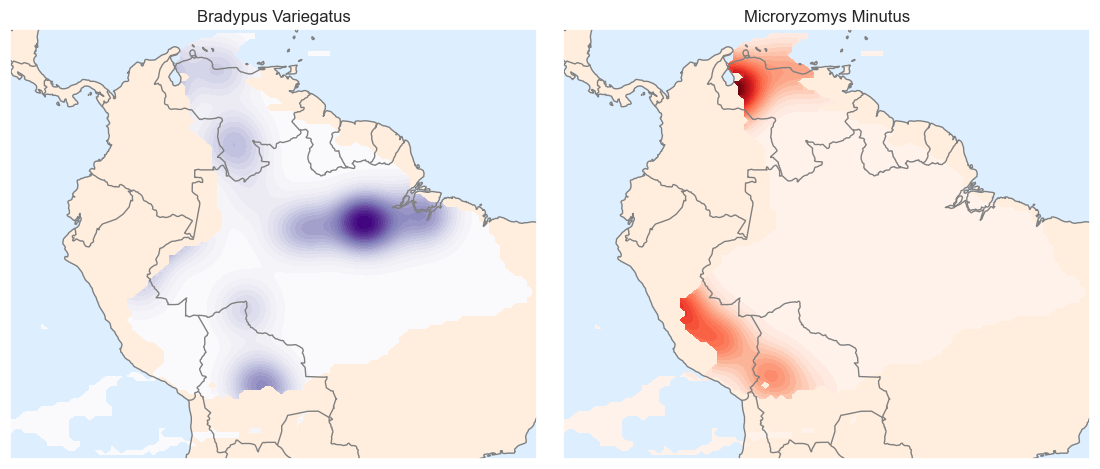

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Fetch data from the sklearn dataset containing species distributions
data = fetch_species_distributions()

# Define grid based on geographical extent
xgrid = np.linspace(data.train['dd long'].min(), data.train['dd long'].max(), 100)  # Longitude grid
ygrid = np.linspace(data.train['dd lat'].min(), data.train['dd lat'].max(), 100)   # Latitude grid

# Resize land_reference to match the grid dimensions
land_reference = data.coverages[6]  # Extract land reference coverage
land_reference_resized = zoom(land_reference, 
                              (len(ygrid) / land_reference.shape[0], 
                               len(xgrid) / land_reference.shape[1]), 
                              order=1)  # Resize land reference to match grid dimensions

# Create a grid for contour plotting
X, Y = np.meshgrid(xgrid, ygrid)  # Create meshgrid for longitude and latitude
land_mask = (land_reference_resized > -9999)  # Create mask to identify land (not ocean)
land_mask_flat = land_mask.flatten()  # Flatten mask for easier indexing
xy = np.vstack([Y.ravel(), X.ravel()]).T  # Stack coordinates for grid points
xy_land = xy[land_mask_flat]  # Select grid points that are on land
xy_land_rad = np.radians(xy_land)  # Convert coordinates to radians for spherical calculations

# Extract species data
species = np.array([d.decode('ascii').startswith('micro') for d in data.train['species']], dtype='int')
latlon = np.vstack([data.train['dd lat'], data.train['dd long']]).T

# Create two side-by-side plots with PlateCarree projection
fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)  # Adjust spacing between subplots
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']  # Names of species for titles
cmaps = ['Purples', 'Reds']  # Color maps for different species

# Loop over each subplot to create individual maps
for i, axi in enumerate(ax):
    axi.set_title(species_names[i])  # Set title for each subplot

    # Set the extent of the map using PlateCarree projection
    axi.set_extent([X.min(), X.max(), Y.min(), Y.max()], crs=ccrs.PlateCarree())
    axi.add_feature(cfeature.LAND, color='#FFEEDD')  # Add land feature with specified color
    axi.add_feature(cfeature.OCEAN, color='#DDEEFF')  # Add ocean feature with specified color
    axi.add_feature(cfeature.COASTLINE, edgecolor='gray')  # Add coastline with gray edges
    axi.add_feature(cfeature.BORDERS, edgecolor='gray')  # Add country borders with gray edges

    # Print the number of samples for this species
    species_mask = (species == i)
    print(f"Number of samples for species '{species_names[i]}':", np.sum(species_mask))

    # Construct a spherical kernel density estimate of the species distribution
    if np.any(species_mask):
        kde = KernelDensity(bandwidth=0.03, metric='haversine')  # Define KDE with haversine metric
        latlon_species = latlon[species_mask]
        kde.fit(np.radians(latlon_species))  # Fit KDE to the species data in radians

        # Evaluate KDE only on land and exclude ocean areas
        Z = np.full(land_mask_flat.shape[0], -9999.0)  # Initialize density array with -9999
        Z[land_mask_flat] = np.exp(kde.score_samples(xy_land_rad))  # Compute densities and apply mask
        Z = Z.reshape(X.shape)  # Reshape density array to match grid shape

        # Plot contours of the density
        levels = np.linspace(0, Z.max(), 25)  # Define contour levels
        contour = axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i], transform=ccrs.PlateCarree())  # Plot contours

# Display the plot
plt.show()  

Compared to the simple scatter plot we initially used, this visualization paints a much clearer picture of the geographical distribution of observations of these two species.

## Example: Not-So-Naive Bayes

This example looks at Bayesian generative classification with KDE, and demonstrates how to use the Scikit-Learn architecture to create a custom estimator.

In Naive Bayes Classification Notebook, we took a look at naive Bayesian classification, in which we created a simple generative model for each class, and used these models to build a fast classifier.
For Gaussian naive Bayes, the generative model is a simple axis-aligned Gaussian.
With a density estimation algorithm like KDE, we can remove the "naive" element and perform the same classification with a more sophisticated generative model for each class.
It's still Bayesian classification, but it's no longer naive.

The general approach for generative classification is this:

1. Split the training data by label.

2. For each set, fit a KDE to obtain a generative model of the data.
   This allows you for any observation $x$ and label $y$ to compute a likelihood $P(x~|~y)$.
   
3. From the number of examples of each class in the training set, compute the *class prior*, $P(y)$.

4. For an unknown point $x$, the posterior probability for each class is $P(y~|~x) \propto P(x~|~y)P(y)$.
   The class which maximizes this posterior is the label assigned to the point.

The algorithm is straightforward and intuitive to understand; the more difficult piece is couching it within the Scikit-Learn framework in order to make use of the grid search and cross-validation architecture.

This is the code that implements the algorithm within the Scikit-Learn framework; we will step through it following the code block:

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on Kernel Density Estimation (KDE)
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):     # Initialize the KDEClassifier with specified bandwidth and kernel.
        
        self.bandwidth = bandwidth  # Set the bandwidth for KDE
        self.kernel = kernel        # Set the kernel type for KDE
        
    def fit(self, X, y):                                      # Fit the KDEClassifier to the training data.
        
        self.classes_ = np.sort(np.unique(y))  # Get the sorted list of unique class labels
        training_sets = [X[y == yi] for yi in self.classes_]       # Create a list of training data for each class
        
        # Fit a KernelDensity model for each class
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        
        # Compute log prior probabilities for each class
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        
        return self  # Return the instance itself
    
    def predict_proba(self, X):                               # Compute the class probabilities for the input samples.
        
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T         # Compute log probabilities for each class
        
        # Compute class probabilities by exponentiating log probabilities and adjusting with log priors
        result = np.exp(logprobs + self.logpriors_)
        
        # Normalize to get probabilities
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):                                     # Predict class labels for the input samples.
       
        return self.classes_[np.argmax(self.predict_proba(X), 1)]  # Predict the class with the highest probability

### The anatomy of a custom estimator

Let's step through this code and discuss the essential features:

```python
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
```

Each estimator in Scikit-Learn is a class, and it is most convenient for this class to inherit from the ``BaseEstimator`` class as well as the appropriate mixin, which provides standard functionality.
For example, among other things, here the ``BaseEstimator`` contains the logic necessary to clone/copy an estimator for use in a cross-validation procedure, and ``ClassifierMixin`` defines a default ``score()`` method used by such routines.

Next comes the class initialization method:

```python
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
```

This is the actual code that is executed when the object is instantiated with ``KDEClassifier()``.
In Scikit-Learn, it is important that *initialization contains no operations* other than assigning the passed values by name to ``self``.
This is due to the logic contained in ``BaseEstimator`` required for cloning and modifying estimators for cross-validation, grid search, and other functions.
Similarly, all arguments to ``__init__`` should be explicit: i.e. ``*args`` or ``**kwargs`` should be avoided, as they will not be correctly handled within cross-validation routines.

Next comes the ``fit()`` method, where we handle training data:

```python 
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
```

Here we find the unique classes in the training data, train a ``KernelDensity`` model for each class, and compute the class priors based on the number of input samples.
Finally, ``fit()`` should always return ``self`` so that we can chain commands. For example:
```python
label = model.fit(X, y).predict(X)
```
Notice that each persistent result of the fit is stored with a trailing underscore (e.g., ``self.logpriors_``).
This is a convention used in Scikit-Learn so that you can quickly scan the members of an estimator (using IPython's tab completion) and see exactly which members are fit to training data.

Finally, we have the logic for predicting labels on new data:
```python
    def predict_proba(self, X):
        logprobs = np.vstack([model.score_samples(X)
                              for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]
```
Because this is a probabilistic classifier, we first implement ``predict_proba()`` which returns an array of class probabilities of shape ``[n_samples, n_classes]``.
Entry ``[i, j]`` of this array is the posterior probability that sample ``i`` is a member of class ``j``, computed by multiplying the likelihood by the class prior and normalizing.

Finally, the ``predict()`` method uses these probabilities and simply returns the class with the largest probability.

### Using our custom estimator

Let's try this custom estimator on a problem we have seen before: the classification of hand-written digits.
Here we will load the digits, and compute the cross-validation score for a range of candidate bandwidths using the ``GridSearchCV`` meta-estimator 

In [21]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV  # Updated import for GridSearchCV

# Load the Digits dataset
digits = load_digits()

# Define a range of bandwidth values to search over using a logarithmic scale
bandwidths = 10 ** np.linspace(0, 2, 100)

# Create a GridSearchCV object to search for the best bandwidth for KDEClassifier
# The parameter grid specifies the bandwidth values to be tested
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})

# Fit the GridSearchCV object to the digits dataset
# This performs cross-validation to find the best bandwidth for the KDEClassifier
grid.fit(digits.data, digits.target)

# Extract the validation scores for each combination of parameters tested
# `grid.cv_results_['mean_test_score']` contains the mean validation scores for each parameter combination
scores = grid.cv_results_['mean_test_score']

Next we can plot the cross-validation score as a function of bandwidth:

{'bandwidth': 6.135907273413174}
accuracy = 0.9677298050139276


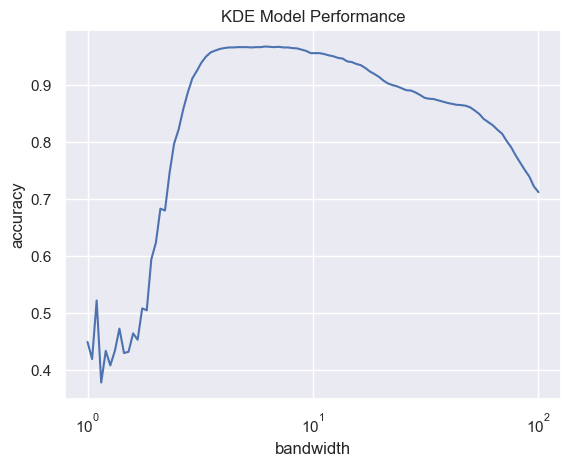

In [22]:
# Create a semi-logarithmic plot of bandwidths versus scores
# plt.semilogx plots the x-axis on a logarithmic scale and the y-axis on a linear scale
plt.semilogx(bandwidths, scores)

# Label the x-axis as 'bandwidth'
plt.xlabel('bandwidth')

# Label the y-axis as 'accuracy'
plt.ylabel('accuracy')

# Set the title of the plot to 'KDE Model Performance'
plt.title('KDE Model Performance')

# Display the best parameters found by GridSearchCV
print(grid.best_params_)

# Print the best score achieved by the GridSearchCV, which corresponds to the highest accuracy
print('accuracy =', grid.best_score_)

We see that this not-so-naive Bayesian classifier reaches a cross-validation accuracy of just over 96%; this is compared to around 80% for the naive Bayesian classification:

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Perform cross-validation using Gaussian Naive Bayes
mean_score = cross_val_score(GaussianNB(), digits.data, digits.target).mean()

mean_score

0.8069281956050759

One benefit of such a generative classifier is interpretability of results: for each unknown sample, we not only get a probabilistic classification, but a *full model* of the distribution of points we are comparing it to!
If desired, this offers an intuitive window into the reasons for a particular classification that algorithms like SVMs and random forests tend to obscure.

If you would like to take this further, there are some improvements that could be made to our KDE classifier model:

- we could allow the bandwidth in each class to vary independently
- we could optimize these bandwidths not based on their prediction score, but on the likelihood of the training data under the generative model within each class (i.e. use the scores from ``KernelDensity`` itself rather than the global prediction accuracy)

Finally, if you want some practice building your own estimator, you might tackle building a similar Bayesian classifier using Gaussian Mixture Models instead of KDE.